# SegFormer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import cv2
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, feature_extractor, num_classes=150):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.feature_extractor = feature_extractor
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Ensure mask is in grayscale

        # Extract pixel values
        image_inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = image_inputs["pixel_values"].squeeze(0)  # Remove extra batch dimension

        # Resize mask to match model output size (e.g., 128x128)
        mask = mask.resize((128, 128), Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)

        # Ensure mask values are within the range [0, self.num_classes - 1]
        mask = np.clip(mask, 0, self.num_classes - 1)
        mask = torch.tensor(mask)

        return {"pixel_values": pixel_values, "labels": mask}


In [ ]:
# Initialize feature extractor
feature_extractor = SegformerFeatureExtractor()

#Civil War and Drone
train_dataset = CustomDataset(images_dir="/content/drive/MyDrive/DroneSyriaCombined/train_images", masks_dir="/content/drive/MyDrive/DroneSyriaCombined/train_masks", feature_extractor=feature_extractor)
val_dataset = CustomDataset(images_dir="/content/drive/MyDrive/DroneSyriaCombined/validation_images", masks_dir="/content/drive/MyDrive/DroneSyriaCombined/validation_masks", feature_extractor=feature_extractor)


# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# Initialize the model

# For loading the trained model
#model_path = "/content/drive/MyDrive/DroneSyriaCombined/model_segFormer_V1"
#model = SegformerForSemanticSegmentation.from_pretrained(model_path)
#model.to(device)

# For obtaining the initial model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model.to(device)
model.train()


# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss(ignore_index=255)  # Set ignore_index for invalid labels

# Define the IoU calculation function
def compute_iou(pred, target, num_classes=150):
    iou_list = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).float().sum().item()
        union = (pred_inds | target_inds).float().sum().item()

        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union

        iou_list.append(iou)

    return np.nanmean(iou_list)



In [ ]:
# Training loop
import time

num_epochs = 50  # Set your number of epochs
train_losses = []
train_ious = []
val_losses = []
val_ious = []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0
    total_train_iou = 0

    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=inputs['pixel_values'])
        loss = criterion(outputs.logits, inputs['labels'].long())
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        with torch.no_grad():
            preds = torch.argmax(outputs.logits, dim=1)
            batch_iou = compute_iou(preds, inputs['labels'])
            total_train_iou += batch_iou

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_iou = total_train_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_ious.append(avg_train_iou)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_iou = 0

    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(pixel_values=inputs['pixel_values'])
            loss = criterion(outputs.logits, inputs['labels'].long())
            total_val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            batch_iou = compute_iou(preds, inputs['labels'])
            total_val_iou += batch_iou

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)

    # Record epoch time
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, "
          f"Time: {epoch_time:.2f} seconds")

# Print final statistics
final_time = sum(epoch_times)
print(f"Total training time: {final_time:.2f} seconds")

Epoch 1/50, Train Loss: 2.1909, Train IoU: 0.0071, Val Loss: 1.7033, Val IoU: 0.0187, Time: 202.59 seconds
Epoch 2/50, Train Loss: 1.2658, Train IoU: 0.0126, Val Loss: 1.1445, Val IoU: 0.0292, Time: 64.50 seconds
Epoch 3/50, Train Loss: 0.9537, Train IoU: 0.0163, Val Loss: 0.7258, Val IoU: 0.0692, Time: 63.27 seconds
Epoch 4/50, Train Loss: 0.7218, Train IoU: 0.0236, Val Loss: 0.5508, Val IoU: 0.1207, Time: 63.83 seconds
Epoch 5/50, Train Loss: 0.6063, Train IoU: 0.0322, Val Loss: 0.4596, Val IoU: 0.2678, Time: 63.43 seconds
Epoch 6/50, Train Loss: 0.4860, Train IoU: 0.0467, Val Loss: 0.3884, Val IoU: 0.3542, Time: 64.62 seconds
Epoch 7/50, Train Loss: 0.4223, Train IoU: 0.0694, Val Loss: 0.3664, Val IoU: 0.5096, Time: 63.72 seconds
Epoch 8/50, Train Loss: 0.3885, Train IoU: 0.0960, Val Loss: 0.3517, Val IoU: 0.5297, Time: 71.55 seconds
Epoch 9/50, Train Loss: 0.3971, Train IoU: 0.1219, Val Loss: 0.3356, Val IoU: 0.5162, Time: 64.62 seconds
Epoch 10/50, Train Loss: 0.3386, Train IoU: 0

In [ ]:
save_directory = "/content/drive/MyDrive/DroneSyriaCombined/model_segFormer_V1"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
model.save_pretrained(save_directory)

In [ ]:
# ORIGINAL VISUALIZATION TRANSPARENT

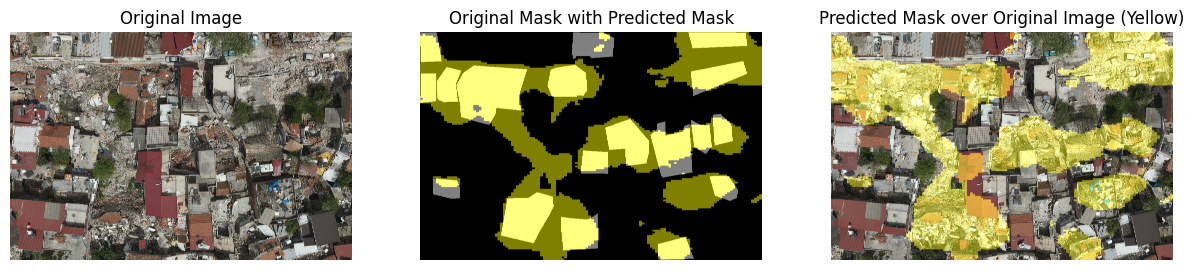

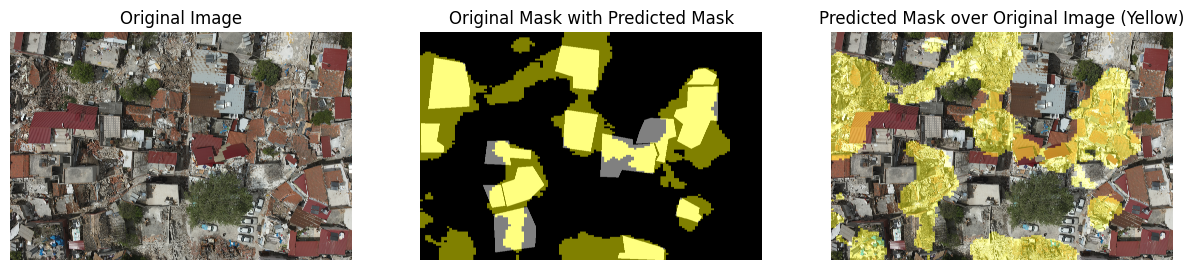

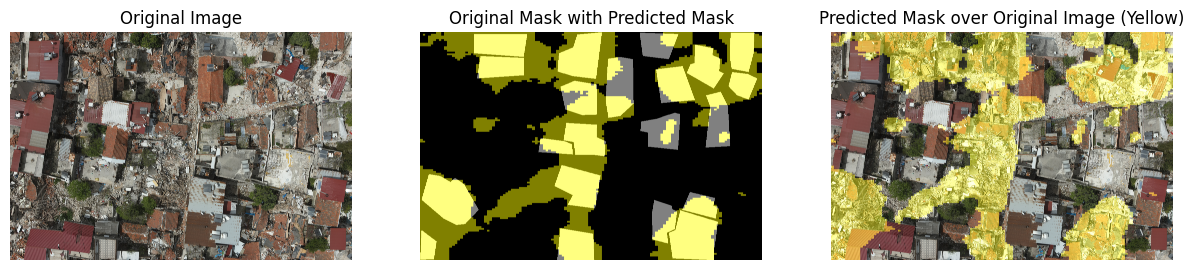

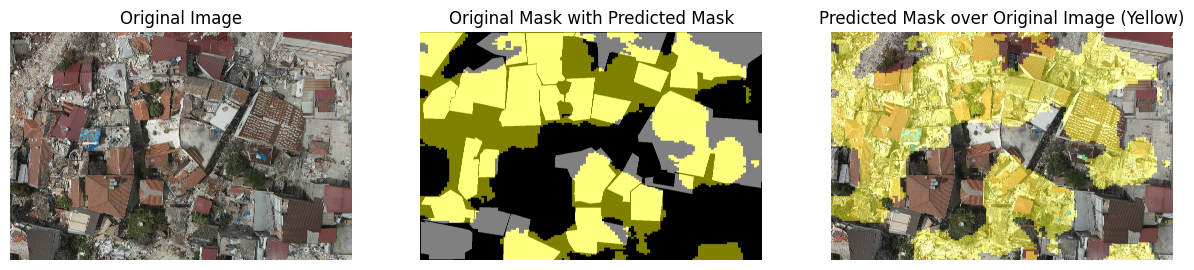

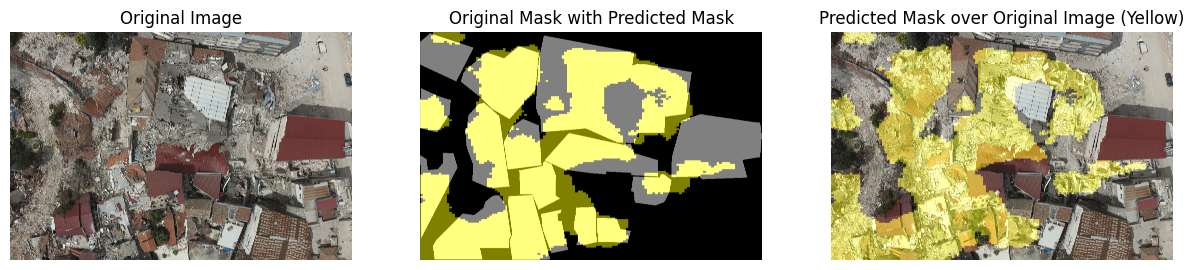

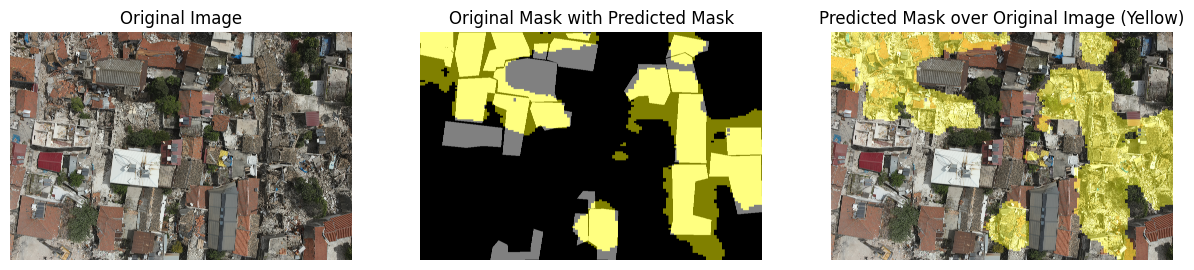

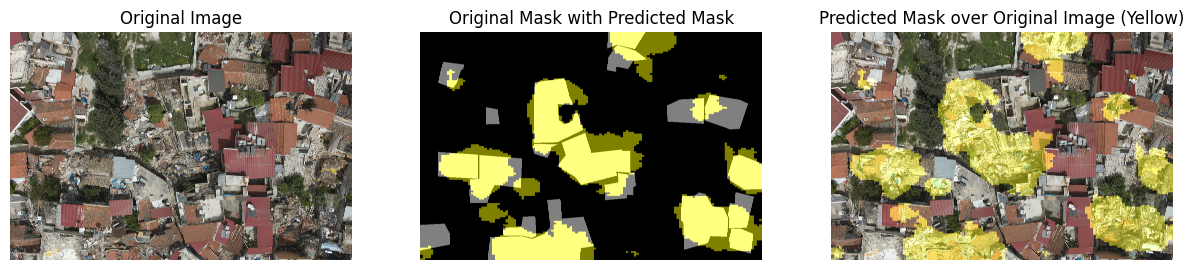

In [ ]:
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os

for val_idx in range(50, len(val_dataset)):
    sample = val_dataset[val_idx]

    # Prepare the sample for model prediction
    input_image = sample["pixel_values"].unsqueeze(0).to(device)

    # Get the model prediction
    with torch.no_grad():
        output = model(pixel_values=input_image)

    # Get the predicted mask
    predicted_mask = torch.argmax(output.logits.squeeze(), dim=0).cpu().numpy()

    # Load the original image and mask for visualization
    original_image = Image.open(os.path.join("/content/drive/MyDrive/DroneSyriaCombined/validation_images", val_dataset.images[val_idx])).convert("RGB")
    original_mask = Image.open(os.path.join("/content/drive/MyDrive/DroneSyriaCombined/validation_masks", val_dataset.masks[val_idx])).convert("L")

    # Convert images to NumPy arrays
    original_image = np.array(original_image)
    original_mask = np.array(original_mask)

    # Ensure the predicted mask is the same shape as the original image
    predicted_mask = predicted_mask.astype(np.uint8)
    predicted_mask_resized = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Resize original mask to match the size of the original image
    original_mask_resized = cv2.resize(original_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert the resized original mask to three channels
    original_mask_rgb = cv2.merge([original_mask_resized]*3)

    # Create a yellow mask for the predicted mask (255, 255, 0 in RGB)
    yellow_mask = np.zeros_like(original_image)
    yellow_mask[..., 0] = 255
    yellow_mask[..., 1] = 255

    # Ensure yellow_mask and predicted_mask_resized have the same shape
    assert yellow_mask.shape[:2] == predicted_mask_resized.shape, f"Shapes of yellow_mask ({yellow_mask.shape[:2]}) and predicted_mask_resized ({predicted_mask_resized.shape}) do not match."

    # Apply the predicted mask to the yellow mask
    yellow_predicted_mask = cv2.bitwise_and(yellow_mask, yellow_mask, mask=predicted_mask_resized)

    # Plot the original image, original mask, and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # Predicted Mask Over Original Mask
    blended_image_mask = cv2.addWeighted(original_mask_rgb, 0.5, yellow_predicted_mask, 0.5, 0)
    axs[1].imshow(blended_image_mask)
    axs[1].set_title("Original Mask with Predicted Mask")
    axs[1].axis("off")

    # Predicted Mask Over Image
    blended_image = cv2.addWeighted(original_image, 1.0, yellow_predicted_mask, 0.4, 0)
    axs[2].imshow(blended_image)
    axs[2].set_title("Predicted Mask over Original Image (Yellow)")
    axs[2].axis("off")

    plt.show()


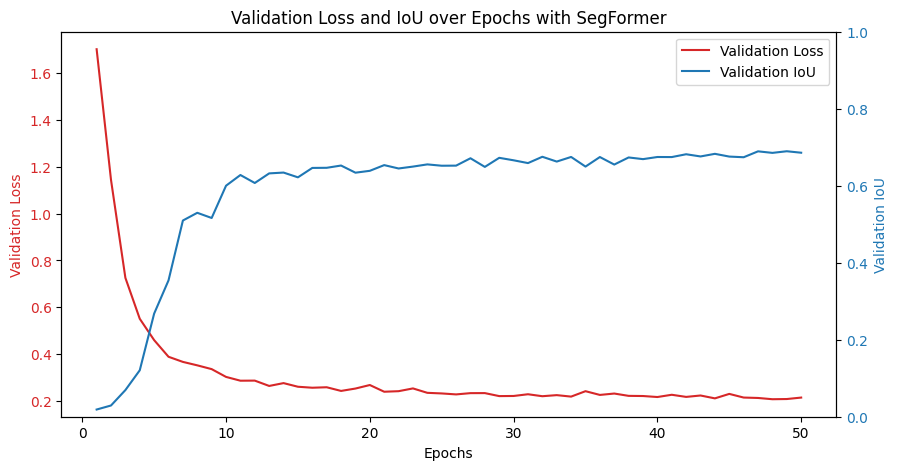

In [ ]:
import matplotlib.pyplot as plt

# Plotting validation loss and IoU on the same plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot validation loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(range(1, len(val_losses) + 1), val_losses, color=color, label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for IoU
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation IoU', color=color)
ax2.plot(range(1, len(val_ious) + 1), val_ious, color=color, label='Validation IoU')
ax2.tick_params(axis='y', labelcolor=color)

# Set the range for IoU from 0 to 1
ax2.set_ylim([0, 1])

# Move the IoU scale to the right
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Validation Loss and IoU over Epochs with SegFormer')
plt.show()


# U-Net

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, OneHotMeanIoU , Accuracy, BinaryIoU
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint

In [ ]:
def load_data(images_path, masks_path):
    image_files = sorted(os.listdir(images_path))  # Sort image files by name
    mask_files = sorted(os.listdir(masks_path))    # Sort mask files by name

    images = []
    masks = []

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(images_path, image_file)
        mask_path = os.path.join(masks_path, mask_file)

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read masks as grayscale

        if image is None or mask is None:
            print(f"Error loading image or mask: {image_file}, {mask_file}")
            continue

        images.append(image)
        masks.append(mask)

    return images, masks

def preprocess_data(images, masks, img_size=(1024, 1024)):
    processed_images = []
    processed_masks = []

    for image, mask in zip(images, masks):
        # Resize images and masks to a fixed size
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize images to range [0, 1]
        image = image / 255.0

        # Normalize masks to range [0, 1] and convert to 4D tensor
        mask = np.expand_dims(mask, axis=-1) / 255.0

        processed_images.append(image)
        processed_masks.append(mask)

    # Convert input data to numpy arrays
    processed_images = np.array(processed_images)
    processed_masks = np.array(processed_masks)

    return processed_images, processed_masks

In [ ]:
def unet(input_size=(1024, 1024, 3)):
#Build the model
    inputs = Input(input_size)
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[BinaryIoU(name='IoU')])
    model.summary()

    return model

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['IoU'], label='Training IoU')
    plt.plot(history.history['val_IoU'], label='Validation IoU')
    plt.title('IoU vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.show()

In [ ]:
# NEW COMBINED SPLITTED ONE

In [ ]:
train_images_path = "/content/drive/MyDrive/DroneSyriaCombined/train_images"
train_masks_path = "/content/drive/MyDrive/DroneSyriaCombined/train_masks"
val_images_path = "/content/drive/MyDrive/DroneSyriaCombined/validation_images"
val_masks_path = "/content/drive/MyDrive/DroneSyriaCombined/validation_masks"

In [ ]:
train_images, train_masks = load_data(train_images_path, train_masks_path)
val_images, val_masks = load_data(val_images_path, val_masks_path)

In [ ]:
X_train, y_train = preprocess_data(train_images, train_masks)
X_val, y_val = preprocess_data(val_images, val_masks)

In [ ]:
kernel_initializer =  'he_uniform'

fileBest = '/content/drive/MyDrive/DroneSyriaCombined/model_unet_V1/best_IoU_CombinedUnet_V1.h5'
checkpoint = ModelCheckpoint(fileBest, monitor='val_IoU', verbose=1, save_best_only=True, mode='max')

model = unet(input_size=X_train[0].shape)
history = model.fit(X_train, y_train, batch_size=8, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])

In [ ]:
plot_history(history)

In [ ]:
model.save("/content/drive/MyDrive/segmentation_model_IoU_69_preserve_True.h5")

In [ ]:
## YELLOW MASK

In [ ]:
def predict_and_visualize(model, test_images, test_masks, idx):
    test_image = test_images[idx]
    test_mask = test_masks[idx]

    # prediction with model
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8) * 255  # Transforming predicted mask to binary form

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    #blended_image = cv2.addweighted(test_mask, 1.0, predicted_mask.squeeze(), 0.3, 1)
    plt.imshow(test_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask Over Original Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    #blended_image = cv2.addweighted(test_image, 1.0, predicted_mask.squeeze(), 0.3, 1)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask Over Image')
    plt.axis('off')

    plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Plotting validation loss and IoU on the same plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot validation loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(range(1, len(val_losses) + 1), val_losses, color=color, label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for IoU
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation IoU', color=color)
ax2.plot(range(1, len(val_ious) + 1), val_ious, color=color, label='Validation IoU')
ax2.tick_params(axis='y', labelcolor=color)

# Set the range for IoU from 0 to 1
ax2.set_ylim([0, 1])

# Move the IoU scale to the right
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Validation Loss and IoU over Epochs with SegFormer')
plt.show()


In [ ]:
#load model from drive
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Final Project/best_model/best_IoU_CivilWar_V1.h5')

In [ ]:
for idx in range(0,len(X_val)):
  predict_and_visualize(model, X_val, y_val, idx)

In [ ]:
import pickle
import os

train_folder = '/content/drive/MyDrive/DroneSyriaCombined/PickleDataSets_UNET/train'
test_folder = '/content/drive/MyDrive/DroneSyriaCombined/PickleDataSets_UNET/test'

In [ ]:
# If you prefer using pickle:
with open(os.path.join(train_folder, "X_train_V1.pkl"), "wb") as f:
    pickle.dump(X_train, f)

with open(os.path.join(train_folder, "y_train_V1.pkl"), "wb") as f:
    pickle.dump(y_train, f)

with open(os.path.join(test_folder, "X_val_V1.pkl"), "wb") as f:
    pickle.dump(X_val, f)

with open(os.path.join(test_folder, "y_val_V1.pkl"), "wb") as f:
    pickle.dump(y_val, f)

In [ ]:
with open(os.path.join(train_folder, "X_train_V1.pkl"), "rb") as f:
    X_train = pickle.load(f)

with open(os.path.join(train_folder, "y_train_V1.pkl"), "rb") as f:
    y_train = pickle.load(f)

with open(os.path.join(test_folder, "X_val_V1.pkl"), "rb") as f:
    X_val = pickle.load(f)

with open(os.path.join(test_folder, "y_val_V1.pkl"), "rb") as f:
    y_val = pickle.load(f)